In [1]:
%matplotlib inline

In [2]:
import warnings
warnings.filterwarnings("ignore")

from dataclasses import dataclass
from datetime import datetime
import math
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import operator
import pandas as pd
import seaborn as sns

mpl.rcParams['figure.figsize'] = [8, 5]

## NPHET IEMAG 2021-06-28 Model Scenario Projections vs Reported Data

This notebook compares the NPHET IEMAG 2021-06-28 model scenario projections with reported data, for 2021-07-01 to 2021-09-30. The projections are the mean values from Table 1 in the [2021-06--28 NPHET letter to the Minister for Health](https://assets.gov.ie/138789/3fe6b992-45e8-4a1c-b4c2-5e4a6131ad53.pdf).

Note:
* The focus is on cases only, as daily data are currently not provided for hospital admissions, ICU admissions, and deaths. These will be included when they are available again.

<img src="figures/20210628_nphet_letter_table1.png" alt="2021-06-28 NPHET Letter - Table 1" width="60%">

<img src="figures/20210628_nphet_optimistic_monthly.jpeg" width="60%">

<img src="figures/20210628_nphet_central1_monthly.jpeg" width="60%">

<img src="figures/20210628_nphet_central2_monthly.jpeg" width="60%">

<img src="figures/20210628_nphet_pessimistic_monthly.jpeg" width="60%">

Monthly figures were posted in this [Twitter thread](https://twitter.com/President_MU/status/1410315246791802884)

### Load the reported case data

This is a daily snapshot of the [Covid-19 Daily Statistics](https://covid-19.geohive.ie/datasets/d8eb52d56273413b84b0187a4e9117be_0/explore?location=53.385818%2C-8.057012%2C7.64&showTable=true) on [Ireland's COVID-19 Data Hub](https://covid-19.geohive.ie/)

In [3]:
casesdf = pd.read_csv('./data/CovidStatisticsProfileHPSCIrelandOpenData.csv', parse_dates=["Date"], date_parser=lambda x: datetime.strptime(x, "%Y/%m/%d %H:%M:%S+00"))
casesdf = casesdf[casesdf.Date>='2021-07-01'][['Date', 'ConfirmedCovidCases']]
casesdf.rename(columns={'ConfirmedCovidCases': 'Cases'}, inplace=True)
casesdf.Cases = casesdf.Cases.cumsum()
casesdf['Scenario'] = 'Reported'

### Scenario data 2021-07-01 to 2021-09-30, based on Table 1 above

In [4]:
scenario_dates = pd.date_range('2021-07-01', '2021-09-30')
july_dates = pd.date_range('2021-07-01', '2021-07-31')
august_dates = pd.date_range('2021-08-01', '2021-08-31')

@dataclass(frozen=True)
class Scenario:
    mean_cases: int
    color: int
    dates: pd.DatetimeIndex
        
        
scenarios = {
    'No Delta': Scenario(21000, 0, scenario_dates),
    'Optimistic (Jul)': Scenario(9000, 6, july_dates),
    'Optimistic (Aug)': Scenario(9000+23000, 7, august_dates),
    'Optimistic': Scenario(81000, 1, scenario_dates),
    'Central 1 (Jul)': Scenario(10000, 6, july_dates),
    'Central 1 (Aug)': Scenario(10000+46000, 7, august_dates),
    'Central 1': Scenario(187000, 2, scenario_dates),
    'Central 2 (Jul)': Scenario(16000, 6, july_dates),
    'Central 2 (Aug)': Scenario(16000+106000, 7, august_dates),
    'Central 2': Scenario(408000, 3, scenario_dates),
    'Pessimistic (Jul)': Scenario(20000, 6, july_dates),
    'Pessimistic (Aug)': Scenario(197000+23000, 7, august_dates),
    'Pessimistic': Scenario(681000, 4, scenario_dates),
}

scenariodf = pd.DataFrame({'Date': np.concatenate([x.dates for x in scenarios.values()]), 
                           'Scenario': np.concatenate([[x] * len(y.dates) for x, y in scenarios.items()]), 
                           'Cases': np.concatenate([[x.mean_cases] * len(x.dates) for x in scenarios.values()])})

### NPHET scenarios vs reported cases

In [5]:
default_palette = sns.color_palette()
generate_dashes = lambda plot_scenarios:[(2,2)] * len(plot_scenarios) + ['']
generate_palette = lambda plot_scenarios:[default_palette[scenarios[x].color] for x in plot_scenarios] + [default_palette[5]]

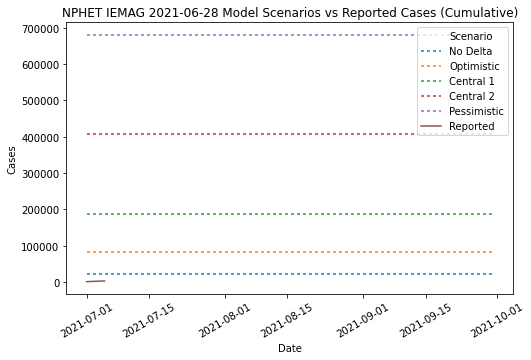

In [6]:
plot_scenarios = ['No Delta', 'Optimistic', 'Central 1', 'Central 2', 'Pessimistic']
ax = sns.lineplot(data=pd.concat((scenariodf[scenariodf.Scenario.isin(plot_scenarios)], casesdf), ignore_index=True), x='Date', y='Cases', hue='Scenario', style='Scenario', dashes=generate_dashes(plot_scenarios), palette=generate_palette(plot_scenarios))
ax.set_title('NPHET IEMAG 2021-06-28 Model Scenarios vs Reported Cases (Cumulative)')
plt.legend(loc='upper right')
plt.xticks(rotation=30);
plt.savefig('./figures/nphet20210628_all_scenarios_vs_reported_cases.png', bbox_inches="tight")

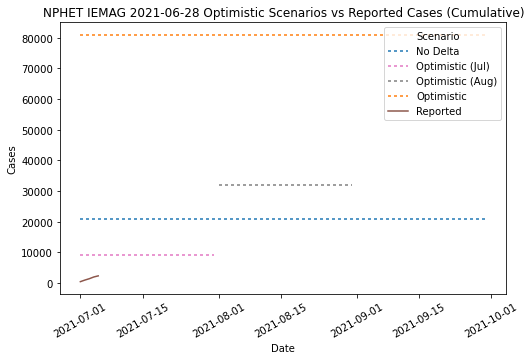

In [7]:
plot_scenarios = ['No Delta', 'Optimistic (Jul)', 'Optimistic (Aug)', 'Optimistic']
ax = sns.lineplot(data=pd.concat((scenariodf[scenariodf.Scenario.isin(plot_scenarios)], casesdf), ignore_index=True), x='Date', y='Cases', hue='Scenario', style='Scenario', dashes=generate_dashes(plot_scenarios), palette=generate_palette(plot_scenarios))
ax.set_title('NPHET IEMAG 2021-06-28 Optimistic Scenarios vs Reported Cases (Cumulative)')
plt.legend(loc='upper right')
plt.xticks(rotation=30);
plt.savefig('./figures/nphet20210628_optimistic_scenarios_vs_reported_cases.png', bbox_inches="tight")

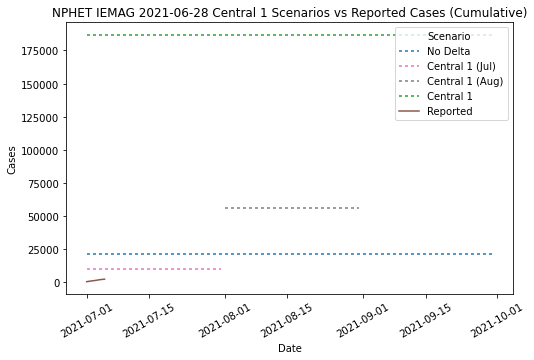

In [8]:
plot_scenarios = ['No Delta', 'Central 1 (Jul)', 'Central 1 (Aug)', 'Central 1']
ax = sns.lineplot(data=pd.concat((scenariodf[scenariodf.Scenario.isin(plot_scenarios)], casesdf), ignore_index=True), x='Date', y='Cases', hue='Scenario', style='Scenario', dashes=generate_dashes(plot_scenarios), palette=generate_palette(plot_scenarios))
ax.set_title('NPHET IEMAG 2021-06-28 Central 1 Scenarios vs Reported Cases (Cumulative)')
plt.legend(loc='upper right')
plt.xticks(rotation=30);
plt.savefig('./figures/nphet20210628_central1_scenarios_vs_reported_cases.png', bbox_inches="tight")

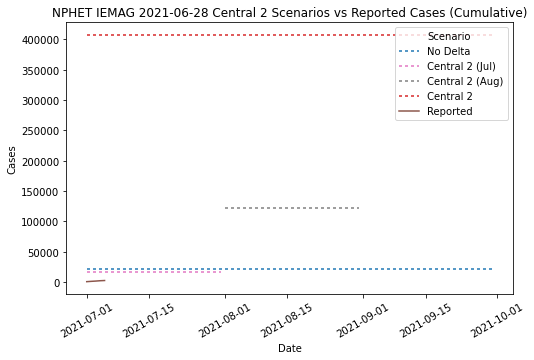

In [9]:
plot_scenarios = ['No Delta', 'Central 2 (Jul)', 'Central 2 (Aug)', 'Central 2']
ax = sns.lineplot(data=pd.concat((scenariodf[scenariodf.Scenario.isin(plot_scenarios)], casesdf), ignore_index=True), x='Date', y='Cases', hue='Scenario', style='Scenario', dashes=generate_dashes(plot_scenarios), palette=generate_palette(plot_scenarios))
ax.set_title('NPHET IEMAG 2021-06-28 Central 2 Scenarios vs Reported Cases (Cumulative)')
plt.legend(loc='upper right')
plt.xticks(rotation=30);
plt.savefig('./figures/nphet20210628_central2_scenarios_vs_reported_cases.png', bbox_inches="tight")

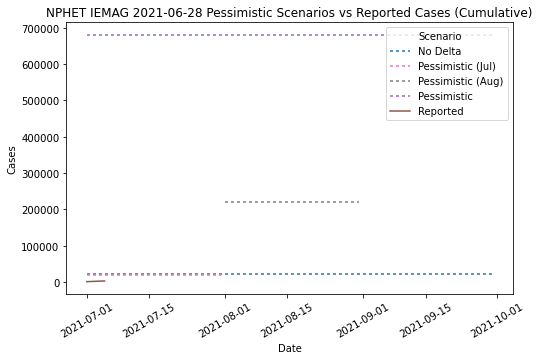

In [10]:
plot_scenarios = ['No Delta', 'Pessimistic (Jul)', 'Pessimistic (Aug)', 'Pessimistic']
ax = sns.lineplot(data=pd.concat((scenariodf[scenariodf.Scenario.isin(plot_scenarios)], casesdf), ignore_index=True), x='Date', y='Cases', hue='Scenario', style='Scenario', dashes=generate_dashes(plot_scenarios), palette=generate_palette(plot_scenarios))
ax.set_title('NPHET IEMAG 2021-06-28 Pessimistic Scenarios vs Reported Cases (Cumulative)')
plt.legend(loc='upper right')
plt.xticks(rotation=30);
plt.savefig('./figures/nphet20210628_pessimistic_scenarios_vs_reported_cases.png', bbox_inches="tight")

### Generate current cases summary

In [11]:
cases_current = casesdf.iloc[-1]
cases_previous = casesdf.iloc[-2]
new_cases = cases_current.Cases - cases_previous.Cases
print(f"""NPHET IEMAG 2021-06-28 Model Scenarios vs Reported Cases

({datetime.strftime(cases_current.Date, "%A %Y-%m-%d")})

- Reported Total: {cases_current.Cases} (+{new_cases})
- % Scenario Duration ({len(scenario_dates)} days): {len(casesdf)*100/len(scenario_dates):.1f}%""")

for scenario in ['Optimistic (Jul)', 'Optimistic']:
    mean_cases = scenarios[scenario].mean_cases
    print(f'- % {scenario} Scenario Total: {cases_current.Cases*100/mean_cases:.1f}% (+{new_cases*100/mean_cases:.1f}%)')

NPHET IEMAG 2021-06-28 Model Scenarios vs Reported Cases

(Monday 2021-07-05)

- Reported Total: 2335 (+365)
- % Scenario Duration (92 days): 5.4%
- % Optimistic (Jul) Scenario Total: 25.9% (+4.1%)
- % Optimistic Scenario Total: 2.9% (+0.5%)
